## Contents

1. [Preprocessing Tweets](#preprocessing-tweets)

In [1]:
import pandas as pd
import nltk
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, silhouette_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
nltk.download("wordnet")
nltk.download("stopwords")
nltk.download('punkt');

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/michaelromanski/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/michaelromanski/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/michaelromanski/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Preprocessing Tweets

In [2]:
df = pd.read_csv("data/tweets.csv", encoding='ISO-8859-1')

df.columns = ["unprocessed_tweet", "product", "emotion"]

df.head(3)

,unprocessed_tweet,product,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion


In [3]:
text = df["unprocessed_tweet"]
text

0       .@wesley83 I have a 3G iPhone. After 3 hrs twe...
1       @jessedee Know about @fludapp ? Awesome iPad/i...
2       @swonderlin Can not wait for #iPad 2 also. The...
3       @sxsw I hope this year's festival isn't as cra...
4       @sxtxstate great stuff on Fri #SXSW: Marissa M...
                              ...                        
9088                        Ipad everywhere. #SXSW {link}
9089    Wave, buzz... RT @mention We interrupt your re...
9090    Google's Zeiger, a physician never reported po...
9091    Some Verizon iPhone customers complained their...
9092    Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...
Name: unprocessed_tweet, Length: 9093, dtype: object

In [4]:
from nltk.corpus import stopwords

stop_words = stopwords.words("english")
stop_words = [i.replace("'", '') for i in stop_words]

stop_words[-5:]

['werent', 'won', 'wont', 'wouldn', 'wouldnt']

In [5]:
ex = "[^a-zA-Z0-9\s]"

text = text.str.replace(ex, "", regex=True)
text = text.str.lower()
text

0       wesley83 i have a 3g iphone after 3 hrs tweeti...
1       jessedee know about fludapp  awesome ipadiphon...
2       swonderlin can not wait for ipad 2 also they s...
3       sxsw i hope this years festival isnt as crashy...
4       sxtxstate great stuff on fri sxsw marissa maye...
                              ...                        
9088                            ipad everywhere sxsw link
9089    wave buzz rt mention we interrupt your regular...
9090    googles zeiger a physician never reported pote...
9091    some verizon iphone customers complained their...
9092    rt mention google tests checkin offers at sxsw...
Name: unprocessed_tweet, Length: 9093, dtype: object

In [6]:
from nltk.tokenize import word_tokenize

tokenized_text = text.apply(lambda t: word_tokenize(str(t)))
tokenized_text

0       [wesley83, i, have, a, 3g, iphone, after, 3, h...
1       [jessedee, know, about, fludapp, awesome, ipad...
2       [swonderlin, can, not, wait, for, ipad, 2, als...
3       [sxsw, i, hope, this, years, festival, isnt, a...
4       [sxtxstate, great, stuff, on, fri, sxsw, maris...
                              ...                        
9088                       [ipad, everywhere, sxsw, link]
9089    [wave, buzz, rt, mention, we, interrupt, your,...
9090    [googles, zeiger, a, physician, never, reporte...
9091    [some, verizon, iphone, customers, complained,...
9092    [rt, mention, google, tests, checkin, offers, ...
Name: unprocessed_tweet, Length: 9093, dtype: object

In [7]:
filtered_text = tokenized_text.apply(lambda x: [word for word in x if word not in stop_words])
filtered_text

0       [wesley83, 3g, iphone, 3, hrs, tweeting, risea...
1       [jessedee, know, fludapp, awesome, ipadiphone,...
2           [swonderlin, wait, ipad, 2, also, sale, sxsw]
3       [sxsw, hope, years, festival, crashy, years, i...
4       [sxtxstate, great, stuff, fri, sxsw, marissa, ...
                              ...                        
9088                       [ipad, everywhere, sxsw, link]
9089    [wave, buzz, rt, mention, interrupt, regularly...
9090    [googles, zeiger, physician, never, reported, ...
9091    [verizon, iphone, customers, complained, time,...
9092    [rt, mention, google, tests, checkin, offers, ...
Name: unprocessed_tweet, Length: 9093, dtype: object

In [8]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
lemmatized_text = filtered_text.apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
lemmatized_str = lemmatized_text.apply(lambda x: ' '.join(x))
lemmatized_str

0       wesley83 3g iphone 3 hr tweeting riseaustin de...
1       jessedee know fludapp awesome ipadiphone app l...
2                   swonderlin wait ipad 2 also sale sxsw
3       sxsw hope year festival crashy year iphone app...
4       sxtxstate great stuff fri sxsw marissa mayer g...
                              ...                        
9088                            ipad everywhere sxsw link
9089    wave buzz rt mention interrupt regularly sched...
9090    google zeiger physician never reported potenti...
9091    verizon iphone customer complained time fell b...
9092       rt mention google test checkin offer sxsw link
Name: unprocessed_tweet, Length: 9093, dtype: object

In [9]:
df["processed_tweet"] = lemmatized_str
df.head()

,unprocessed_tweet,product,emotion,processed_tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,wesley83 3g iphone 3 hr tweeting riseaustin de...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,jessedee know fludapp awesome ipadiphone app l...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,swonderlin wait ipad 2 also sale sxsw
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,sxsw hope year festival crashy year iphone app...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,sxtxstate great stuff fri sxsw marissa mayer g...


In [10]:
df.to_csv("data/processed_tweets.csv")

In [11]:
df_binary = df.copy()
df_binary = df_binary[df_binary["emotion"].isin(["Negative emotion", "Positive emotion"])]

df_binary["emotion_encoded"] = df_binary["emotion"].replace("Negative emotion", 0).replace("Positive emotion", 1)
df_binary.to_csv("data/processed_tweets_binary.csv")

In [12]:
df_binary

,unprocessed_tweet,product,emotion,processed_tweet,emotion_encoded
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,wesley83 3g iphone 3 hr tweeting riseaustin de...,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,jessedee know fludapp awesome ipadiphone app l...,1
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,swonderlin wait ipad 2 also sale sxsw,1
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,sxsw hope year festival crashy year iphone app...,0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,sxtxstate great stuff fri sxsw marissa mayer g...,1
...,...,...,...,...,...
9077,@mention your PR guy just convinced me to swit...,iPhone,Positive emotion,mention pr guy convinced switch back iphone gr...,1
9079,&quot;papyrus...sort of like the ipad&quot; - ...,iPad,Positive emotion,quotpapyrussort like ipadquot nice lol sxsw la...,1
9080,Diller says Google TV &quot;might be run over ...,Other Google product or service,Negative emotion,diller say google tv quotmight run playstation...,0
9085,I've always used Camera+ for my iPhone b/c it ...,iPad or iPhone App,Positive emotion,ive always used camera iphone bc image stabili...,1


In [13]:
X = df_binary['processed_tweet']
y = df_binary['emotion_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [150]:
bin_forest_pipe = Pipeline([
    ('tf', TfidfVectorizer(min_df=.01, max_df=.9, stop_words=stop_words, ngram_range=(1,3))),
    ('rf', RandomForestClassifier(random_state=42, min_samples_split = 12, class_weight='balanced_subset'))
])

In [146]:
X

0       wesley83 3g iphone 3 hr tweeting riseaustin de...
1       jessedee know fludapp awesome ipadiphone app l...
2                   swonderlin wait ipad 2 also sale sxsw
3       sxsw hope year festival crashy year iphone app...
4       sxtxstate great stuff fri sxsw marissa mayer g...
                              ...                        
9077    mention pr guy convinced switch back iphone gr...
9079    quotpapyrussort like ipadquot nice lol sxsw la...
9080    diller say google tv quotmight run playstation...
9085    ive always used camera iphone bc image stabili...
9088                            ipad everywhere sxsw link
Name: processed_tweet, Length: 3548, dtype: object

---

In [141]:
bin_log_pipe = Pipeline([
    ('tf', TfidfVectorizer(min_df=.01, max_df=.9, stop_words=stop_words, ngram_range=(1,3))),
    ('lr', LogisticRegression(random_state=42, class_weight='balanced'))
])

In [147]:
bin_forest_pipe.fit(X_train, y_train)

y_pred_forest = bin_forest_pipe.predict(X_test)
forest_test_acc = accuracy_score(y_test, y_pred_forest)
forest_test_acc

0.8507042253521127

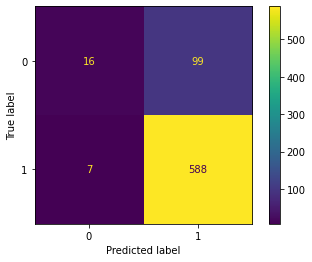

In [148]:
cfm_forest = confusion_matrix(y_test, y_pred_forest)
ConfusionMatrixDisplay(cfm_forest).plot()

In [152]:
print(classification_report(y_test, y_pred_forest))

              precision    recall  f1-score   support

           0       0.70      0.14      0.23       115
           1       0.86      0.99      0.92       595

    accuracy                           0.85       710
   macro avg       0.78      0.56      0.57       710
weighted avg       0.83      0.85      0.81       710



In [153]:
bin_forest_pipe_grid = Pipeline([
    ('tf', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
    
])

In [156]:
forest_param_grid = {
    'tf__min_df': [.01, .05, .1],
    'tf__max_df': [.85, .90, .95],
    'tf__stop_words': ['english'],
    'tf__ngram_range': [(1,1), (1,2), (1,3)],
    'rf__n_estimators': [50, 100, 150],
    'rf__min_samples_split': [10, 20, 30],
    'rf__class_weight': ['none','balanced', 'balanced_subsample']
    
}

In [158]:
bin_forest_grid = GridSearchCV(bin_forest_pipe_grid, forest_param_grid, cv=5)
bin_forest_grid.fit(X_train, y_train)

/Users/michaelromanski/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
1215 fits failed out of a total of 3645.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1215 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/michaelromanski/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/michaelromanski/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/michaelromanski/anaconda3/envs/learn-env/lib/pyth

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'rf__class_weight': ['none', 'balanced',
                                              'balanced_subsample'],
                         'rf__min_samples_split': [10, 20, 30],
                         'rf__n_estimators': [100, 200, 300],
                         'tf__max_df': [0.85, 0.9, 0.95],
                         'tf__min_df': [0.01, 0.05, 0.1],
                         'tf__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'tf__stop_words': ['english']})

In [159]:
print(bin_forest_grid.best_params_)
print(bin_forest_grid.best_score_)

{'rf__class_weight': 'balanced', 'rf__min_samples_split': 10, 'rf__n_estimators': 100, 'tf__max_df': 0.9, 'tf__min_df': 0.01, 'tf__ngram_range': (1, 3), 'tf__stop_words': 'english'}
0.8224116302754799


In [140]:
bin_log_pipe.fit(X_train, y_train)

y_pred_log = bin_log_pipe.predict(X_test)
log_test_acc = accuracy_score(y_test, y_pred_log)
log_test_acc

InvalidParameterError: The 'class_weight' parameter of LogisticRegression must be an instance of 'dict', a str among {'balanced'} or None. Got 'balanced_subsample' instead.

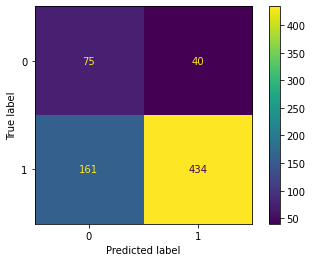

In [77]:
cfm_log = confusion_matrix(y_test, y_pred_log)
ConfusionMatrixDisplay(cfm_log).plot()

In [78]:
print(classification_report(y_test,y_pred_log))

              precision    recall  f1-score   support

           0       0.32      0.65      0.43       115
           1       0.92      0.73      0.81       595

    accuracy                           0.72       710
   macro avg       0.62      0.69      0.62       710
weighted avg       0.82      0.72      0.75       710



In [42]:
tf = TfidfVectorizer(min_df = .01, max_df = .9)

X_train_tf = tf.fit_transform(X_train.values)
X_train_tf = X_train_tf.toarray()
X_test_tf = tf.transform(X_test.values)
X_test_tf = X_test_tf.toarray()

In [43]:
nb_model = GaussianNB()

In [44]:
nb_model.fit(X_train_tf, y_train)

y_pred_nb = nb_model.predict(X_test_tf)
nb_test_acc = accuracy_score(y_test, y_pred_nb)
nb_test_acc

0.4535211267605634

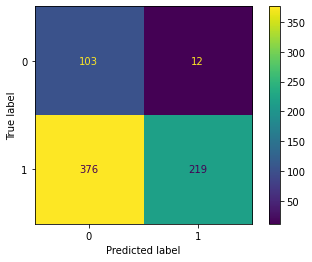

In [45]:
cfm_nb = confusion_matrix(y_test, y_pred_nb)
ConfusionMatrixDisplay(cfm_nb).plot()

In [46]:
print(classification_report(y_test,y_pred_nb))

              precision    recall  f1-score   support

           0       0.22      0.90      0.35       115
           1       0.95      0.37      0.53       595

    accuracy                           0.45       710
   macro avg       0.58      0.63      0.44       710
weighted avg       0.83      0.45      0.50       710

